<a href="https://colab.research.google.com/github/raymondwcs/learning_bert/blob/master/OpenRice(torch_nn).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/toastynews/openrice-senti.git
!pip -q install transformers

Cloning into 'openrice-senti'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 10 (delta 1), reused 7 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.
     |████████████████████████████████| 2.6 MB 8.5 MB/s 
     |████████████████████████████████| 3.3 MB 61.1 MB/s 
     |████████████████████████████████| 636 kB 57.2 MB/s 
     |████████████████████████████████| 895 kB 60.4 MB/s 


In [2]:
from transformers import BertModel, BertTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import torch.nn as nn

# Set the random seed
np.random.seed(0)
torch.manual_seed(0)

# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

CHECKPOINT = 'bert-base-chinese'
BATCH_SIZE = 16
MAX_LEN = 256

train_data = pd.read_csv("openrice-senti/train.tsv", delimiter="\t")
test_data = pd.read_csv("openrice-senti/test.tsv", delimiter="\t")
valid_data = pd.read_csv("openrice-senti/valid.tsv", delimiter="\t")

class_names = ['cry', 'ok', 'smile']

def to_sentiment(rating):
  if rating == 'cry':
    return 0
  elif rating == 'ok':
    return 1
  else: 
    return 2

train_data['sentiment'] = train_data['label'].apply(to_sentiment)
test_data['sentiment'] = test_data['label'].apply(to_sentiment)
valid_data['sentiment'] = valid_data['label'].apply(to_sentiment)

In [3]:
train_data.head()

,label,text_a,sentiment
0,smile,正宗大板燒 🐿🐿TOP開左都一段日子，餐廳都好幾層！今日就嚟試下千房(^^) 大板燒專門店🤤...,2
1,ok,"唔見得比其他酒家特別好食 一行7人到此酒家食晚飯, 7道海鮮 + 雞連炒飯 & 炒菜共10道...",1
2,cry,質素同價錢唔成正比 今日嚟到呢間牛肉麵店食晏，一個人食坐嘅位比較窄，但佢環境都好衛生同埋裝修...,0
3,smile,燒汁雞扒刈包好味 上星期和朋友去杏花邨睇波鞋啲時候，覺得肚餓，於是就落咗一層睇下有咩下午餐好...,2
4,ok,"上海妹子 下午茶 我地一聚埋就會好想搵個地方坐低飲啖茶食個飽, 妹子佢話想食小籠包,下一秒我...",1


In [4]:
tokenizer = BertTokenizer.from_pretrained(CHECKPOINT)

class OpenRiceDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      # pad_to_max_length=True,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = OpenRiceDataset(
    reviews=df.text_a.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=1
  )

train_data_loader = create_data_loader(train_data.iloc[0:1024,:], tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(valid_data.iloc[0:64,:], tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_data.iloc[0:64,:], tokenizer, MAX_LEN, BATCH_SIZE)


In [5]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(CHECKPOINT)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    # _, pooled_output = self.bert(
    output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    # output = self.drop(pooled_output)
    output = self.drop(output.pooler_output)
    return self.out(output)

In [6]:
data = next(iter(train_data_loader))
# print(data.keys())
# print(data['input_ids'].shape)
# print(data['attention_mask'].shape)
# print(data['targets'].shape)

model = SentimentClassifier(len(class_names))
model = model.to(device)

input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

import torch.nn.functional as F
model(input_ids,attention_mask)

F.softmax(model(input_ids, attention_mask), dim=1)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([16, 256])
torch.Size([16, 256])


tensor([[0.1247, 0.1103, 0.7650],
        [0.3379, 0.1845, 0.4776],
        [0.2083, 0.1806, 0.6111],
        [0.1997, 0.1880, 0.6123],
        [0.1782, 0.2034, 0.6184],
        [0.1402, 0.1577, 0.7021],
        [0.0791, 0.1716, 0.7493],
        [0.3202, 0.1473, 0.5325],
        [0.1728, 0.1861, 0.6411],
        [0.1387, 0.0761, 0.7852],
        [0.2628, 0.0874, 0.6499],
        [0.2407, 0.1053, 0.6540],
        [0.1661, 0.2636, 0.5703],
        [0.2247, 0.2465, 0.5288],
        [0.2991, 0.1342, 0.5667],
        [0.2548, 0.1999, 0.5453]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [7]:
EPOCHS = 10

from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [8]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    # print(outputs)

    _, preds = torch.max(outputs, dim=1)

    # print(preds)

    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [9]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [11]:
# %%time
from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler,
    1024
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device,
    64
  )

  print(f'Eval  loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['eval_acc'].append(val_acc)
  history['eval_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    torch.save(model,'saved_model.pt')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 1.0825818832963705 accuracy 0.419921875
Eval   loss 0.888317734003067 accuracy 0.59375

Epoch 2/10
----------
Train loss 0.8810399957001209 accuracy 0.568359375
Eval   loss 0.6926908046007156 accuracy 0.640625

Epoch 3/10
----------
Train loss 0.6629872359335423 accuracy 0.70703125
Eval   loss 0.6738585978746414 accuracy 0.71875

Epoch 4/10
----------
Train loss 0.48452283907681704 accuracy 0.791015625
Eval   loss 0.6423756182193756 accuracy 0.734375

Epoch 5/10
----------
Train loss 0.4008030124241486 accuracy 0.826171875
Eval   loss 0.5731344595551491 accuracy 0.734375

Epoch 6/10
----------
Train loss 0.1940940383647103 accuracy 0.9404296875
Eval   loss 0.6057029366493225 accuracy 0.765625

Epoch 7/10
----------
Train loss 0.13919258074020036 accuracy 0.9609375
Eval   loss 0.8055872768163681 accuracy 0.796875

Epoch 8/10
----------
Train loss 0.08085592719726264 accuracy 0.9775390625
Eval   loss 0.914274699985981 accuracy 0.765625

Epoch 9/10
-------

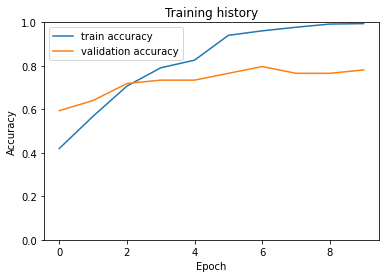

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['eval_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [13]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  64
)

test_acc.item()

0.828125

In [14]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [15]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         cry       0.91      0.95      0.93        21
          ok       0.75      0.71      0.73        21
       smile       0.82      0.82      0.82        22

    accuracy                           0.83        64
   macro avg       0.83      0.83      0.83        64
weighted avg       0.83      0.83      0.83        64



In [34]:
# review_text='ok無驚喜，穩穩陣陣 連鎖式快餐店的食物一定係穩陣，但唔會有太大的驚喜或新花款。是晚外賣上個friend屋企聚一聚，唔想食燒味飯，又見唔到有焗豬扒飯，只見到鳳爪排骨煲仔飯啱口味D，好彩煲仔飯都可以外賣，只不過無得煲仔上，食下飯焦；煲仔飯就跟中湯加杯中國茶。 唔知個湯係咩湯，湯渣都幾多，不喝也吧！煲仔飯的豉油係另上，鍾意落幾多就幾多，可能無咗個煲仔，個飯顯得較為濕咗D，有兩隻鳳爪，都幾多的細粒排骨，今次D排骨好彩係都有肉食，唔會舊舊都只係骨，個飯合格啦！杯中國茶點綴下又可以幫助消化，唔錯！'
review_text='但係我地黎既目的係食韓燒，點知種類賣相真係嚇死你！啲肉好似冇奄過咁！啲牛肉粒仲瘦過瘦肉，都算啦！點知所有野食燒完後完全冇味！'
# review_text='芒果大合奏~ 次次去都係食呢個，好多層次的芒果，有芒果乾，芒果布丁，芒果肉，芒果雪糕，芒果漿，不同texture, 感覺真係好rich~ 大滿足'
encoded_review = tokenizer.encode_plus(
  review_text,
  add_special_tokens=True,
  max_length=MAX_LEN,
  return_token_type_ids=False,
  # pad_to_max_length=True,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: 但係我地黎既目的係食韓燒，點知種類賣相真係嚇死你！啲肉好似冇奄過咁！啲牛肉粒仲瘦過瘦肉，都算啦！點知所有野食燒完後完全冇味！
Sentiment  : cry


In [33]:
torch.save(model,'saved_model.pt')